# Our First Computer Vision Application (Motion Detection)

A simple computer vision application is motion detection in a video recorded by a fixed camera. Security cameras and doorbell cameras use motion detection to detect when someone is entering the field of view of the camera.

Motion detection can be achieved using a simple computer vision technique known as *frame differencing*. This can be done by computing video frame differences.

## Data loading, visualization, and exploration

Let's load a short video.

In [22]:
from IPython.display import Video
Video('./data/Illinois_highway.mp4', width=350)

Next, we will use OpenCV to capture individual frames from the video.

In [23]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Load a video
cap = cv.VideoCapture('./data/Illinois_highway.mp4')

First let's find out what the frame rate (frames per second) of the video is, how many total frames are there in the video, and what is the resolution of the video.

In [24]:
# Get the frame rate of the video
frame_rate = cap.get(cv.CAP_PROP_FPS)
print('Frame rate:', frame_rate)

# Count the total number of frames in the video
length = int(cap. get(cv. CAP_PROP_FRAME_COUNT))
print('Number of frames in the video:', length)

# Get the width and height of the video
width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
print('Width:', width)
print('Height:', height)


Frame rate: 29.96969696969697
Number of frames in the video: 69
Width: 1920
Height: 1080


As we can see, the frame rate is ~30 fps, which is a common frame rate for regular cameras. 

Next, let's extract a frame from the video.

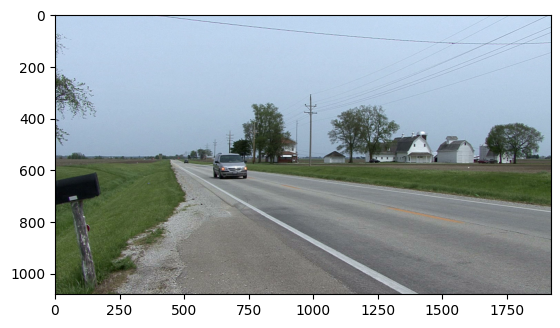

In [25]:
# Extract the first frame of the video
ret, frame = cap.read()

# Convert the grame to RGB color space
frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)

# Show the first frame
plt.imshow(frame)

The function `read()` returns `True` if an image was extracted successfully extracted from the video, and the image (frame) itself. It returns `False` and an empty image if no images was extracted, e.g. because the camera has been disconnected, or there are no more frames in video file.

## Frame differencing

Let's now try to detect where the moving vehicle is. To do so, we find the part of the image that exhibits the highest amount of motion. We can detect motion by subtracting neighboring frames from each other. Pixes in which motion does not occur will have more or less the same values in neighboring frames. Thus subtracting a frame from another will result in a difference close to zero for those pixels. However, for pixels in which motion occurs, the pixels values will have changed significantly between neighboring frames, therefore there difference is going to be non-zero. 

Let's observe this technique in practice. Although the same tricks can be applied to color images, for simplicity we will work with grayscale images from now on.

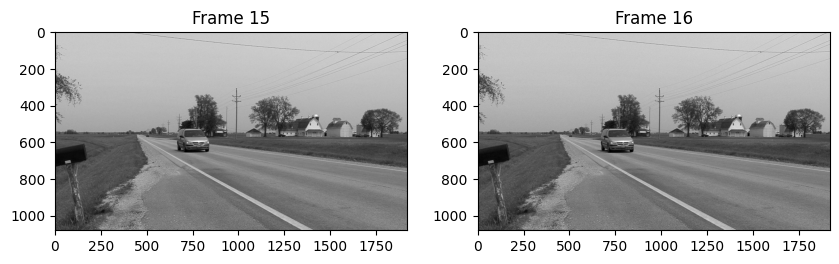

In [26]:
# Extract frame number 15 from the video
cap.set(cv.CAP_PROP_POS_FRAMES, 15)
ret, frame15 = cap.read()
# Convert the frame to gray scale
frame15 = cv.cvtColor(frame15, cv.COLOR_BGR2GRAY)

# Repeat the same for frame number 16
cap.set(cv.CAP_PROP_POS_FRAMES, 16)
ret, frame16 = cap.read()
# Convert the frame to gray scale
frame16 = cv.cvtColor(frame16, cv.COLOR_BGR2GRAY)

# Show the two frames
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1),plt.imshow(frame15, cmap='gray'),plt.title('Frame 15') # Show the image in grayscale
plt.subplot(1, 2, 2),plt.imshow(frame16, cmap='gray'),plt.title('Frame 16')
plt.show()

We cannot tell much of a difference in the two frames, but let's observer what happens when we take their difference. We will use the function `absdiff`, which takes the absolute value of each pixel difference so that we do not end up with negative value pixels.

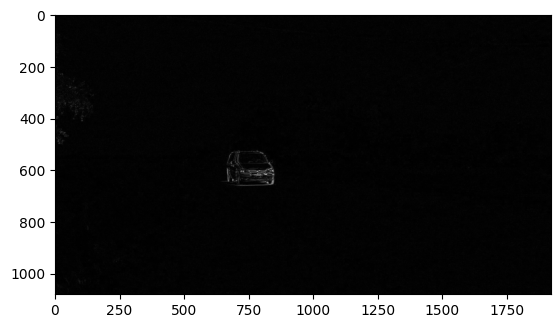

In [27]:
diff = cv.absdiff(frame15, frame16)
plt.imshow(diff, cmap='gray')

We can observe some non-black pixels. Those are the pixels for which the difference was significantly greater than zero. To take a closer look at those values, we can zoom into a small region of the image: 

In [28]:
# Print a patch of the frame difference matrix
print(diff[610:630, 840:855])

[[  8   6   7  20  45  49  24   6   2   1   7  10   3   5   4]
 [ 11  23  27  33  50  38  24  11   9   0   3   3   3   3   2]
 [ 31  36  29  47  58  71  59  34   9   6   5  14  15  12   4]
 [ 19   2  39  44  47  56  43  26  11  27  28  18   5   5  10]
 [ 47  36  38  37  42  25   3   1   2   4   0   4   9   3   4]
 [ 39  39  40  46  38  18  54  44  23   5   2   2  15   1   4]
 [ 90 114 117 119 119 120 102  69  23   3   7   4   8  12  11]
 [ 96 123 124 122 122 121 100  62  22   2   2   8  12   4   6]
 [127 136 141 133 136 121  96  60  17   7   8   3   2   1   4]
 [144 150 136 141 132 129 101  57  17  12  17  12  13   7   1]
 [130 145 147 150 136 140 118  69  25   2  11   7  15   3   2]
 [104  98 101 118  96 100  86  55  25   7   5  10   4   7   1]
 [ 69  66  55  55  58  58  58  39   9   1   3   0   0   1   4]
 [ 32  47  46  46  52  50  44  34  12   5   9  11   7  10   7]
 [ 31  38  38  40  56  52  49  32  10   6  10   5   7   7   2]
 [ 42  45  48  50  66  65  46  29   9   1   4   6   5  

This effect will be more pronounced if we take two frames that are farther apart from each other.

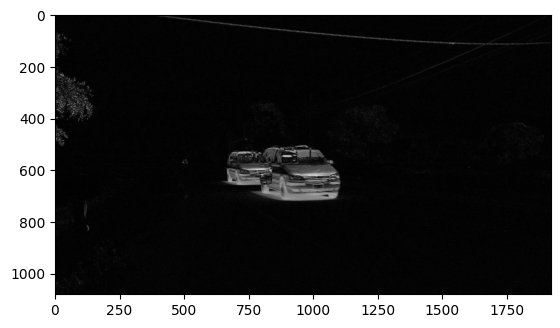

In [29]:
# Extract frame number 35 from the video
cap.set(cv.CAP_PROP_POS_FRAMES, 35)
ret, frame35 = cap.read()
# Convert the frame to gray scale
frame35 = cv.cvtColor(frame35, cv.COLOR_BGR2GRAY)

diff = cv.absdiff(frame15, frame35)
plt.imshow(diff, cmap='gray')

The above frame shows as much motion information about frame 15 as it does about frame 35, which effectively shows the car in two different positions. What if we wanted to only show the motion pixels of frame 15 but not of frame 35? 

To do that we will use two frames of equal distance from frame 15. Those can be frames 5 and 25 (or 10 and 20, etc.). We will calculate the frame difference between each one of them and frame 15, and then we will extract the motion pixels that are common between those two differences.

To extract the motion pixels that are common between the two differences, we will use the function `min()` to take them minimum value of each pixel between the two diff matrices. The motion pixels that correspond to frame 15, will be the same in the two matrices. However, the motion pixels which come from frame 5, will be have a much smaller value in the diff matrix that captures the motion of frames 15 and 25, and vice versa. Therefore by selecting the minimum of each pixel, we end up keeping only the motion pixels that come from frame 15.

Note: to avoid having to deal with edge cases, e.g. where one of the frames ends up being outside of the video limits (e.g. a number smaller than 0 or greater than 69) we will only work with frames that not in the two ends of the video.

Let's try this in practice.

(<Axes: title={'center': 'Motion'}>,
 Text(0.5, 1.0, 'Motion'))

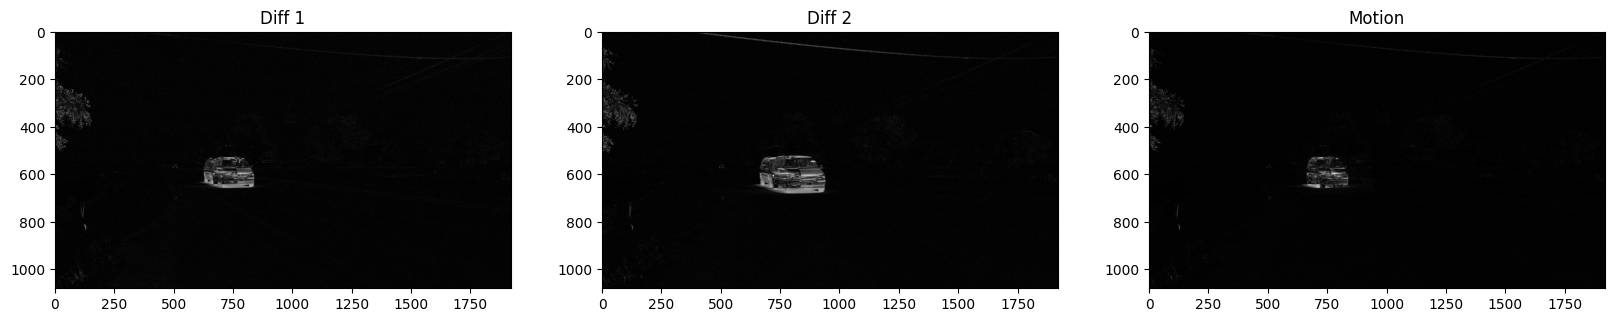

In [30]:
# Extract frame number 5 from the video
cap.set(cv.CAP_PROP_POS_FRAMES, 5)
ret, frame5 = cap.read()
# Convert the frame to gray scale
frame5 = cv.cvtColor(frame5, cv.COLOR_BGR2GRAY)

# Extract frame number 15 from the video
cap.set(cv.CAP_PROP_POS_FRAMES, 15)
ret, frame15 = cap.read()
# Convert the frame to gray scale
frame15 = cv.cvtColor(frame15, cv.COLOR_BGR2GRAY)

# Extract frame number 25 from the video
cap.set(cv.CAP_PROP_POS_FRAMES, 25)
ret, frame25 = cap.read()
# Convert the frame to gray scale
frame25 = cv.cvtColor(frame25, cv.COLOR_BGR2GRAY)

diff1 = cv.absdiff(frame5, frame15)
diff2 = cv.absdiff(frame15, frame25)
motion = cv.min(diff1, diff2)   # Take the minimum of the two differences

# Plot diff1, diff2, and motion frames.
plt.figure(figsize=(20,10))
plt.subplot(1, 3, 1),plt.imshow(diff1, cmap='gray'),plt.title('Diff 1') # Show the image in grayscale
plt.subplot(1, 3, 2),plt.imshow(diff2, cmap='gray'),plt.title('Diff 2')
plt.subplot(1, 3, 3),plt.imshow(motion, cmap='gray'),plt.title('Motion')

## Thresholds

As you can notice the pixel values can range from 0 to 255. If we do not care about the exact value of each pixel but we just want to know which pixels are greater than a certain value, we can set a threshold on the diff matrix. 

In Python we can simply apply the mathematical operator `>` (grater) directly on a matrix and the result will be a matrix of the same size with each value replaced with `True` or `False` depending of that corresponding value was greater than the threshold or not.

The `imshow()` function is smart enough to be able to display a matrix even when the pixel values are binary. The True values are mapped to 255 and the False values are mapped to 0.

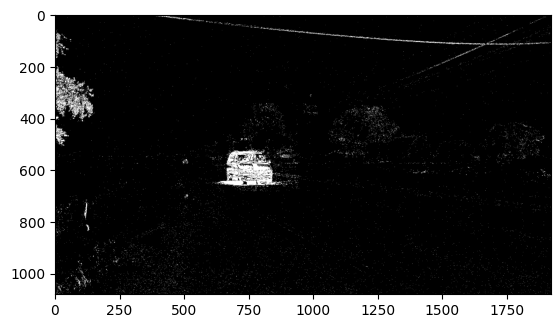

In [31]:
binary_img = motion > 10        # Threshold the image
plt.imshow(binary_img, cmap='gray')

Let's print out a small patch to look inside.

In [32]:
print(binary_img[620:630, 800:810])

[[ True  True False False  True  True  True  True  True  True]
 [ True False False  True  True  True  True  True  True  True]
 [False False False  True False False  True  True  True  True]
 [ True  True  True  True  True  True  True False  True  True]
 [ True  True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True]
 [ True  True False False False False False False False False]
 [ True  True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True]]


OpenCV provides it's own function for applying a threshold to an image. The OpenCV function `threshold()` returns a numeric matrix where values below the threshold become and 0s and values over the threshold become `maxval`, where maxval is a number provided as input to the function. We will use this function from now on as some other OpenCV functions can only work with numeric matrices and not boolean ones. Note that the function `threshold()` provides functionality for automatically detecting the optimal threshold. We will manually pick our thresholds for now.


In [33]:
thresh, binary_img = cv.threshold(motion, thresh = 10, maxval = 255, type = cv.THRESH_BINARY)
print(binary_img[620:630, 800:810])

[[255 255   0   0 255 255 255 255 255 255]
 [255   0   0 255 255 255 255 255 255 255]
 [  0   0   0 255   0   0 255 255 255 255]
 [255 255 255 255 255 255 255   0 255 255]
 [255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255]
 [255 255   0   0   0   0   0   0   0   0]
 [255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255]]


In the displayed binary motion image above, we can see the car pixels, but also a few pixels on the left of the picture, which are the leaves of a tree, probably moving because of the wind.

Now let's try a few different threshold values and see how our output looks.

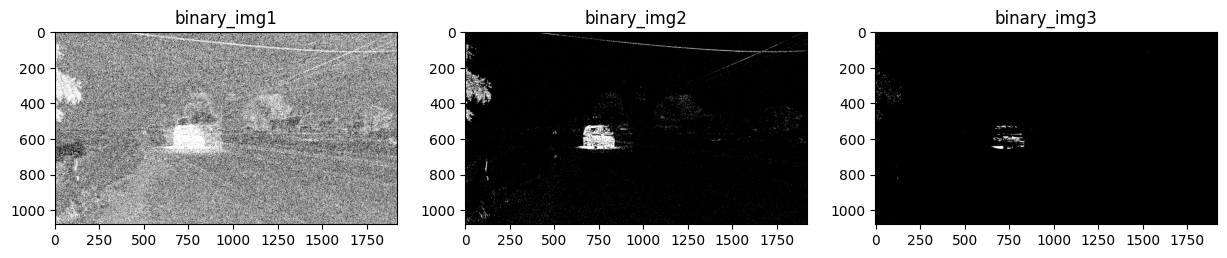

In [34]:
thresh, binary_img1 = cv.threshold(motion, thresh = 1, maxval = 255, type = cv.THRESH_BINARY) 
thresh, binary_img2 = cv.threshold(motion, thresh = 10, maxval = 255, type = cv.THRESH_BINARY)
thresh, binary_img3 = cv.threshold(motion, thresh = 60, maxval = 255, type = cv.THRESH_BINARY)

plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1),plt.imshow(binary_img1, cmap='gray'),plt.title('binary_img1') # Show the image in grayscale
plt.subplot(1, 3, 2),plt.imshow(binary_img2, cmap='gray'),plt.title('binary_img2')
plt.subplot(1, 3, 3),plt.imshow(binary_img3, cmap='gray'),plt.title('binary_img3')
plt.show()

Setting a threshold of 1 returns too many white pixels, which is the result of the camera noise in the image. A threshold value 60 seems to miss a lot of the pixels of the car. A threshold value of 10 seems to be a good choice.
```

## Connected components

The next question is, how can detect the car? One way to that is to find all the pixels that belong to the car and then calculate their center. The first step of that process is to find the pixels that belong to the car. 

As we see in the displayed motion image, besides the pixels that belong to the car, there are other white pixels as a result of motion in the background (e.g. tree leaves). To keep only the car motion pixels and get rid of all other white pixels, we will find the largest connected component in the image. A [**connected component**](https://en.wikipedia.org/wiki/Connected-component_labeling) is a consecutive set of white pixels which are adjacent to other white pixels. We can assume that since the car is the object exhibiting the highest motion in the image, that will be the largest component. To get all the connected components in the image we will use the OpenCV function `connectedComponentsWithStats()`.

For details about function `connectedComponentsWithStats()`, please refer to the documentation:
https://docs.opencv.org/4.6.0/d3/dc0/group__imgproc__shape.html#gae57b028a2b2ca327227c2399a9d53241

```
function connectedComponentsWithStats():
params:
- binary_img: the thresholded binary image
- connectivity: 8 or 4 for 8-way or 4-way connectivity respectively.
return:
- nb_components returns the number of connected components in the image.
- output returns the labelled image.
- stats returns statistics about the bounding box of each component.
- centroids returns the centroid of each component.

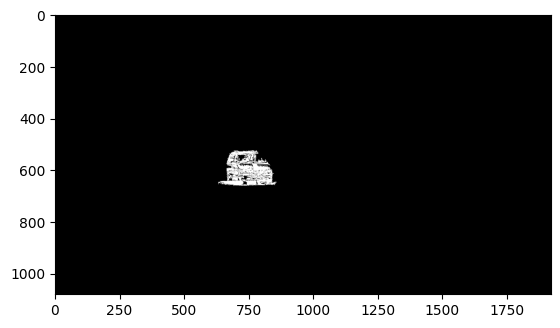

In [35]:
# Threshold the image
thresh, binary_img = cv.threshold(motion, thresh = 10, maxval = 255, type = cv.THRESH_BINARY)

# Find the connected components
nb_components, output, stats, centroids = cv.connectedComponentsWithStats(binary_img, connectivity=4)

# Find the largest non background component.
# Note: range() starts from 1 since 0 is the background label.
max_label, max_size = max([(i, stats[i, cv.CC_STAT_AREA]) for i in range(1, nb_components)], key=lambda x: x[1])

# Keep only the largest component.
binary_img[output != max_label] = 0

# Show the result.
plt.imshow(binary_img, cmap='gray')

Now we have a clean motion image with only the car pixel set to non-zero, although the shadow of the car also captured. To find the center of the car we can calculate the average horizontal and vertical positions of all non-zero pixels by wring our own code, or we can easily access it int the centroid values that the function `connectedComponentsWithStats()` returns.

In [36]:
# Find the centroid of the largest component.
centroid = centroids[max_label]

# print the centroid
print(centroid)

[744.755154   602.87611773]


## Visualizing the results

The centroid values correspond to the horizontal (x) and vertical (y) coordinates in the image, counting from the top-left corner. The coordinates are calculated as floating point numbers. To map to pixel positions, we need convert the numbers to integers. Let's get those pixel positions and draw red dot on top of the motion image so we can see it.

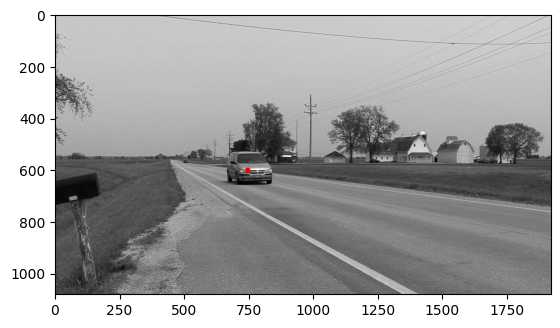

In [37]:
centroid_row = int(centroid[1])         # y-coordinate
centroid_col = int(centroid[0])         # x-coordinate

# Convert grayscale image to RGB color image so we can draw on it with color
color_img = cv.cvtColor(frame15, cv.COLOR_GRAY2RGB)

# Draw the centroid on the result color image
cv.circle(color_img, (centroid_col, centroid_row), 10, (0,0,255), -1)


# Convert the frame to RGB color space
color_img_rgb = cv.cvtColor(color_img, cv.COLOR_BGR2RGB)
# Show the result
plt.imshow(color_img_rgb)
plt.show()

We can also draw a bounding box around the car.

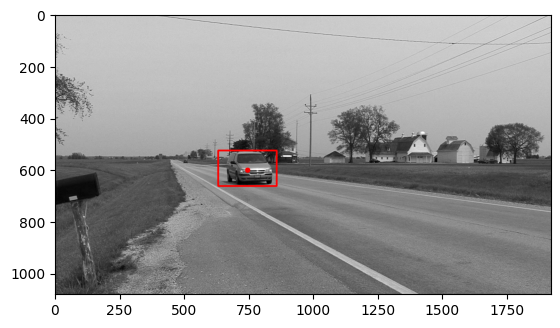

In [38]:
# Draw bounding box around the largest component
# Note: The bounding box is defined by the x, y coordinates of the top left 
# corner and the width and height of the box.
left = int(stats[max_label, cv.CC_STAT_LEFT])
top = int(stats[max_label, cv.CC_STAT_TOP])
width = int(stats[max_label, cv.CC_STAT_WIDTH])
height = int(stats[max_label, cv.CC_STAT_HEIGHT])

# Draw the bounding box as a red rectangle
cv.rectangle(color_img, (left, top), (left+width, top+height), (0,0,255), 5)

# Convert the frame to RGB color space
color_img_rgb = cv.cvtColor(color_img, cv.COLOR_BGR2RGB)
# Show the result
plt.imshow(color_img_rgb)
plt.show()

## Saving the results

We can also save the motion image with the bounding box as a file.

In [39]:
# Save the motion image with the bounding box as a file
cv.imwrite('output/motion_image.png', color_img)

True

What happens if the we try to visualize and save an image that is not in the range of 0-255? Let's try it out.

In [40]:
# Create a matrix with custom values that will be used as an image
my_image = np.array([
    [-2, -2, -2, -2, -2, -2, -2, -2, -2],
    [-2, -2, -2, -2, -2, -2, -2, -2, -2],
    [-2, -2, -2, -2, -2, -2, -2, -2, -2],
    [5, 5, 5, 5, 5, 5, 5, 5, 5],
    [-2, -2, -2, -2, -2, -2, -2, -2, -2],
    [-2, -2, -2, -2, -2, -2, -2, -2, -2],
    [-2, -2, -2, -2, -2, -2, -2, -2, -2],
    [-2, -2, -2, -2, -2, -2, -2, -2, -2]
], dtype=np.float32)

# Resize the image. Note: in OpenCV, the size format is (width, height)
my_image_resized = cv.resize(my_image, (my_image.shape[1]*20, my_image.shape[0]*20), 
    interpolation=cv.INTER_LINEAR)

# Print a patch of the rezized image matrix to see the effect of interpolation.
with np.printoptions(threshold=np.inf): # To print the whole array
    print(my_image_resized[45:95, 0:5])

[[-2.         -2.         -2.         -2.         -2.        ]
 [-2.         -2.         -2.         -2.         -2.        ]
 [-2.         -2.         -2.         -2.         -2.        ]
 [-2.         -2.         -2.         -2.         -2.        ]
 [-2.         -2.         -2.         -2.         -2.        ]
 [-1.825      -1.825      -1.825      -1.825      -1.825     ]
 [-1.475      -1.475      -1.475      -1.475      -1.475     ]
 [-1.125      -1.125      -1.125      -1.125      -1.125     ]
 [-0.77500004 -0.77500004 -0.77500004 -0.77500004 -0.77500004]
 [-0.42500004 -0.42500004 -0.42500004 -0.42500004 -0.42500004]
 [-0.07499996 -0.07499996 -0.07499996 -0.07499996 -0.07499996]
 [ 0.27499992  0.27499992  0.27499992  0.27499992  0.27499992]
 [ 0.625       0.625       0.625       0.625       0.625     ]
 [ 0.9750001   0.9750001   0.9750001   0.9750001   0.9750001 ]
 [ 1.3249999   1.3249999   1.3249999   1.3249999   1.3249999 ]
 [ 1.6749998   1.6749998   1.6749998   1.6749998   1.67

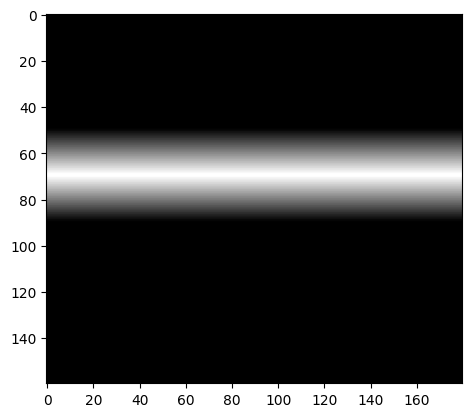

In [41]:
# Display the image
plt.figure(1)
plt.imshow(my_image_resized, cmap='gray')
plt.show()

We notice that the image is displayed correctly, even though the matrix contains negative floating point numbers. This is because Matplotlib's `imshow()` function is smart enough to map the values to the correct range. 

When Matplotlib's imshow function visualizes an array (or a matrix), the behavior depends on the datatype and the colormap (cmap). Here's how it generally handles the display of images with pixel values outside the 0-255 range:

- **Automatic Scaling for Both Integer and Float Arrays**: If `vmin` and `vmax` are not specified, imshow will automatically normalize the pixel values based on the actual minimum and maximum values present in the array, regardless of whether the data is integer or floating-point. This normalization maps the minimum value to the lower bound and the maximum value to the upper bound of the chosen colormap.

- **Manual Normalization with vmin and vmax**: If you specify `vmin` and `vmax`, these values will be used for normalization, and the actual data range will be ignored. Any value below vmin will map to the lower bound of the colormap, and any value above vmax will map to the upper bound, e.g. `imshow(img, vmin=0, vmax=100)`.

- **Colormaps**: Matplotlib applies a colormap (cmap) to map single channel image intensity to colors. You can specify colormaps using the `cmap` keyword argument. The default is often grayscale ('gray'), where low values are displayed as black and high values as white.

The behavior of **OpenCV's** cv2.imshow is somewhat different from Matplotlib's imshow:

- **Datatype Sensitivity**: Unlike Matplotlib, cv2.imshow is more strict about the datatype. If the image is of type `uint8`, cv2.imshow expects pixel values to be in the range [0, 255]. If the image is of floating-point type, cv2.imshow expects the values to be in the range [0.0, 1.0].

- **No Auto-Normalization**: cv2.imshow does not automatically normalize the values of the image. For uint8 (8-bit unsigned integers), anything below 0 is considered 0, and anything above 255 is considered 255. For floating-point images, values below 0.0 are considered 0.0, and values above 1.0 are considered 1.0.

Now let's see what happens when we try to save an image that is not in the range of 0-255. We will use the function `imwrite()` from OpenCV.

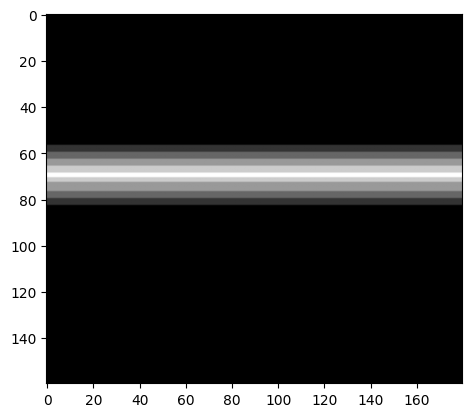

In [42]:
# Write the image to a file
cv.imwrite('output/my_image.jpg', my_image_resized)

# Load the image
my_image2 = cv.imread('output/my_image.jpg', cv.IMREAD_GRAYSCALE)

# Show the image
plt.figure(1)
plt.imshow(my_image2, cmap='gray')
plt.show()

We notice that the displayed image does not smoothly transition from black to white as before. Let's see what do the pixel values look like.

In [43]:
with np.printoptions(threshold=np.inf): # To print the whole array
    print(my_image2[45:95, 0:5])

[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [2 2 2 2 2]
 [2 2 2 2 2]
 [2 2 2 2 2]
 [3 3 3 3 3]
 [3 3 3 3 3]
 [3 3 3 3 3]
 [4 4 4 4 4]
 [4 4 4 4 4]
 [4 4 4 4 4]
 [5 5 5 5 5]
 [5 5 5 5 5]
 [4 4 4 4 4]
 [4 4 4 4 4]
 [3 3 3 3 3]
 [3 3 3 3 3]
 [3 3 3 3 3]
 [3 3 3 3 3]
 [2 2 2 2 2]
 [2 2 2 2 2]
 [2 2 2 2 2]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


Since the pixel values in an image file can only be `uint8` (8-bit unsigned integers), the floating point numbers are rounded to the nearest integer. This is why we see the image with the sharp transition from black to white.

### Normalizing the Image Range

How do we convert an image so that its range is between 0 and 255? We can do that by normalizing the image. Normalization is the process of converting an image to a range of values that are more familiar and easier to work with. For example, we can normalize an image to the range [0, 1] or [0, 255].

In [44]:
# Function that normalizes an image to a given range
def normalize_image(img, new_min=0, new_max=255):
    # Find the minimum and maximum values of the image
    min_val = np.min(img)
    max_val = np.max(img)

    original_range = max_val - min_val
    new_range = new_max - new_min
    
    # Normalize the image
    img_normalized = (((img - min_val) * new_range) / original_range) + new_min
    
    return img_normalized

Let's now use range normalization to convert the image to the range [0, 255] and save it.

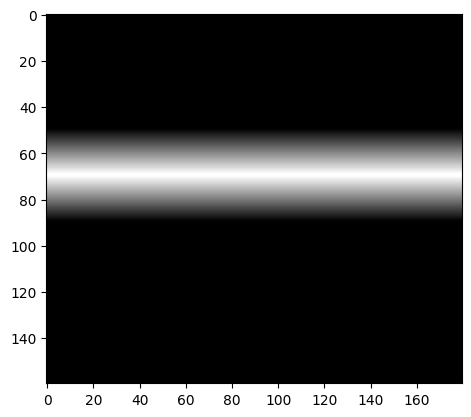

In [45]:
img_normalized = normalize_image(my_image_resized).astype(np.uint8)

# Write the image to a file
cv.imwrite('output/my_normalized_image.jpg', img_normalized)

# Load the image
img_normalized2 = cv.imread('output/my_normalized_image.jpg', cv.IMREAD_GRAYSCALE)

# Show the image
plt.figure(1)
plt.imshow(img_normalized2, cmap='gray')
plt.show()

In [46]:
with np.printoptions(threshold=np.inf): # To print the whole array
    print(img_normalized2[45:95, 0:5])

[[  0   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  6   6   6   6   6]
 [ 19  19  19  19  19]
 [ 33  33  33  33  33]
 [ 44  44  44  44  44]
 [ 58  58  58  58  58]
 [ 71  71  71  71  71]
 [ 84  84  84  84  84]
 [ 98  98  98  98  98]
 [112 112 112 112 112]
 [124 124 124 124 124]
 [137 137 137 137 137]
 [150 150 150 150 150]
 [163 163 163 163 163]
 [176 176 176 176 176]
 [189 189 189 189 189]
 [203 203 203 203 203]
 [215 215 215 215 215]
 [228 228 228 228 228]
 [242 242 242 242 242]
 [255 255 255 255 255]
 [255 255 255 255 255]
 [241 241 241 241 241]
 [228 228 228 228 228]
 [215 215 215 215 215]
 [202 202 202 202 202]
 [189 189 189 189 189]
 [176 176 176 176 176]
 [163 163 163 163 163]
 [150 150 150 150 150]
 [137 137 137 137 137]
 [124 124 124 124 124]
 [111 111 111 111 111]
 [ 98  98  98  98  98]
 [ 84  84  84  84  84]
 [ 70  70  70  70  70]
 [ 58  58  58  58  58]
 [ 45  45  45  45  45]
 [ 32  32  32  32  32]
 [ 19  19  

We can see that the image is now saved correctly.